In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_Fashion_bagging"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def FashionMNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [0]:
models = []
accuracies = [0]
patience = 0

for i in count(1):

    print(f"Train model {i}")
    idx = np.random.choice(len(x_train), size=len(x_train), replace=True)

    x_train_model = x_train[idx]
    y_train_model = y_train[idx]

    model = FashionMNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)
    
    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit(x_train_model,y_train_model,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_test,y_testc),
              shuffle = True,
              callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    if delta >= MODEL_ADDITION_DELTA:
      patience = 0
    else:
      patience += 1

    print(f"Model: {i} added. Resulting score: {acc}, Delta: {delta}, Patience: {patience}")

    if patience >= MODEL_ADDITION_PATIENCE:
      break

Train model 1
Train on 48000 samples, validate on 10000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 49us/step - loss: 2.1791 - accuracy: 0.2923 - val_loss: 2.2077 - val_accuracy: 0.3589
Epoch 2/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.9403 - accuracy: 0.4135 - val_loss: 1.8396 - val_accuracy: 0.4222
Epoch 3/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.6964 - accuracy: 0.4913 - val_loss: 1.5949 - val_accuracy: 0.5272
Epoch 4/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.5038 - accuracy: 0.5497 - val_loss: 1.4287 - val_accuracy: 0.5694
Epoch 5/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.3701 - accuracy: 0.5827 - val_loss: 1.3159 - val_accuracy: 0.5947


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Model: 1 added. Resulting score: 0.5965, Delta: 0.5965, Patience: 0
Train model 2
Train on 48000 samples, validate on 10000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 48us/step - loss: 2.2196 - accuracy: 0.1952 - val_loss: 2.2188 - val_accuracy: 0.2409
Epoch 2/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.9479 - accuracy: 0.3863 - val_loss: 1.8340 - val_accuracy: 0.4186
Epoch 3/5
48000/48000 [==============================] - 2s 42us/step - loss: 1.6889 - accuracy: 0.4462 - val_loss: 1.5745 - val_accuracy: 0.4888
Epoch 4/5
48000/48000 [==============================] - 2s 42us/step - loss: 1.5076 - accuracy: 0.5102 - val_loss: 1.4323 - val_accuracy: 0.5356
Epoch 5/5
48000/48000 [==============================] - 2s 42us/step - loss: 1.3846 - accuracy: 0.5565 - val_loss: 1.3292 - val_accuracy: 0.5683


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Model: 2 added. Resulting score: 0.5904166666666667, Delta: -0.0060833333333333295, Patience: 1
Train model 3
Train on 48000 samples, validate on 10000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 48us/step - loss: 2.2039 - accuracy: 0.1910 - val_loss: 2.1891 - val_accuracy: 0.2126
Epoch 2/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.9122 - accuracy: 0.3539 - val_loss: 1.7992 - val_accuracy: 0.3997
Epoch 3/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.6646 - accuracy: 0.4346 - val_loss: 1.5517 - val_accuracy: 0.4856
Epoch 4/5
48000/48000 [==============================] - 2s 42us/step - loss: 1.4853 - accuracy: 0.5044 - val_loss: 1.4128 - val_accuracy: 0.5294
Epoch 5/5
48000/48000 [==============================] - 2s 43us/step - loss: 1.3652 - accuracy: 0.5475 - val_loss: 1.3117 - val_accuracy: 0.5665


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Model: 3 added. Resulting score: 0.5934166666666667, Delta: 0.0030000000000000027, Patience: 2
Train model 4
Train on 48000 samples, validate on 10000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 48us/step - loss: 2.1976 - accuracy: 0.2345 - val_loss: 2.2014 - val_accuracy: 0.3035
Epoch 2/5
48000/48000 [==============================] - 2s 44us/step - loss: 1.9262 - accuracy: 0.3950 - val_loss: 1.8132 - val_accuracy: 0.4134
Epoch 3/5
48000/48000 [==============================] - 2s 44us/step - loss: 1.6759 - accuracy: 0.4708 - val_loss: 1.5632 - val_accuracy: 0.5160
Epoch 4/5
48000/48000 [==============================] - 2s 44us/step - loss: 1.4988 - accuracy: 0.5304 - val_loss: 1.4200 - val_accuracy: 0.5617
Epoch 5/5
48000/48000 [==============================] - 2s 45us/step - loss: 1.3788 - accuracy: 0.5720 - val_loss: 1.3232 - val_accuracy: 0.5930


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

Model: 4 added. Resulting score: 0.59975, Delta: 0.006333333333333302, Patience: 3


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensamble

In [0]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.596500,1
2,0.590417,2
3,0.593417,3
4,0.599750,4


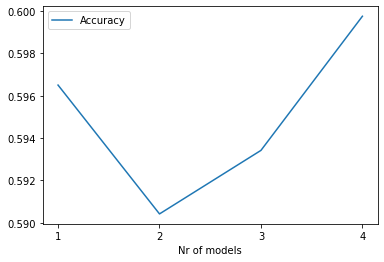

In [0]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [0]:
print("Accuracy: " + str(predict(models, x_test, y_testc)))

100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Accuracy: 0.6004


## Correlation between models

In [0]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


In [0]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 4/4 [00:00<00:00, 266.32it/s]


In [0]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
display(correlation_matrix_df)
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2,3
0,NaN,0.582019,0.640387,0.646138
1,0.582019,NaN,0.627232,0.591769
2,0.640387,0.627232,NaN,0.622149
3,0.646138,0.591769,0.622149,NaN


Average correlation: 0.6182824394115926
